# Fake News Classifier Using Bidirectional LSTM
Dataset: https://www.kaggle.com/c/fake-news/data#

### Loading the dataset 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.shape

(20800, 5)

In [4]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

### Data preprocessing

In [5]:
# Drop NaN values
df = df.dropna()
df.reset_index(inplace = True)
df.shape

(18285, 6)

In [6]:
# Get the Independent Features
X = df.iloc[:,:-1]
X.shape

(18285, 5)

In [7]:
# Get the Dependent Features
y = df['label']
y.shape

(18285,)

In [10]:
# Get the count of each of the unique labels to see dataset distribution
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [22]:
X['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [18]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [19]:
sw = stopwords.words('english')
wn = WordNetLemmatizer()

In [20]:
corpus = []    # list of sentences

for i in range(len(X)):
    
    review = re.sub('[^a-zA-Z]', ' ', X['title'][i])
    review = review.lower()
    review = word_tokenize(review)
    
    review = ' '.join([wn.lemmatize(word) for word in review if word not in sw])
    corpus.append(review)

In [21]:
corpus[0]

'house dem aide even see comey letter jason chaffetz tweeted'

In [24]:
print(len(corpus))

18285


### One-Hot Representation

In [25]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

In [26]:
# Define the vocabulary size
vocab_size = 5000

In [28]:
# This function receives as input a string of text & returns a list of encoded integers each corresponding to a word (or token)
onehot_repr = [one_hot(sent, vocab_size) for sent in corpus]

In [32]:
print(onehot_repr[0])
print(onehot_repr[1])

[536, 1240, 2876, 495, 3590, 2813, 4129, 3489, 3674, 3884]
[1891, 1784, 1607, 4204, 4003, 4485, 1955]


### Embedding Representation

In [33]:
sent_length = 20

# Pads sequences to the same length
embedding_matrix = pad_sequences(onehot_repr, maxlen = sent_length)

In [34]:
print(embedding_matrix)

[[   0    0    0 ... 3489 3674 3884]
 [   0    0    0 ... 4003 4485 1955]
 [   0    0    0 ... 2851 4829 1977]
 ...
 [   0    0    0 ... 1812 4688 3842]
 [   0    0    0 ... 2226 4717 1199]
 [   0    0    0 ... 1328 2933 4280]]


In [35]:
print(embedding_matrix.shape)

(18285, 20)


### Build Model

In [36]:
from keras.models import Sequential
from keras.layers import *

In [37]:
embedded_vector_features = 50

In [38]:
model = Sequential()

model.add(Embedding(vocab_size, embedded_vector_features, input_length = sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            250000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 371,001
Trainable params: 371,001
Non-trainable params: 0
_________________________________________________________________


In [39]:
X_train = np.array(embedding_matrix)
Y_train = np.array(y)

print(X_train.shape , Y_train.shape)

(18285, 20) (18285,)


In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(13713, 20) (4572, 20) (13713,) (4572,)


### Model Training

In [41]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
215/215 [==============================] - 9s 29ms/step - loss: 0.4300 - accuracy: 0.7647 - val_loss: 0.2119 - val_accuracy: 0.9101
Epoch 2/10
215/215 [==============================] - 5s 25ms/step - loss: 0.1322 - accuracy: 0.9508 - val_loss: 0.2260 - val_accuracy: 0.9123
Epoch 3/10
215/215 [==============================] - 6s 26ms/step - loss: 0.0780 - accuracy: 0.9727 - val_loss: 0.2288 - val_accuracy: 0.9138
Epoch 4/10
215/215 [==============================] - 6s 26ms/step - loss: 0.0492 - accuracy: 0.9834 - val_loss: 0.3130 - val_accuracy: 0.9086
Epoch 5/10
215/215 [==============================] - 5s 25ms/step - loss: 0.0333 - accuracy: 0.9914 - val_loss: 0.4073 - val_accuracy: 0.9031
Epoch 6/10
215/215 [==============================] - 5s 25ms/step - loss: 0.0203 - accuracy: 0.9948 - val_loss: 0.4979 - val_accuracy: 0.9097
Epoch 7/10
215/215 [==============================] - 5s 25ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.5326 - val_accuracy: 0.9075

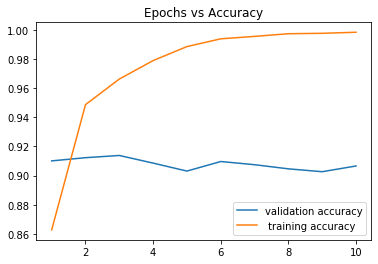

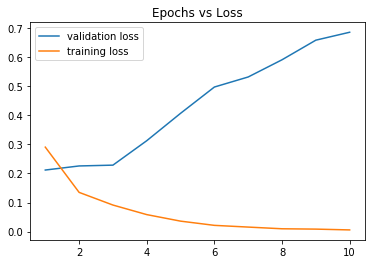

In [44]:
import matplotlib.pyplot as plt

h = hist.history
epochs = range(1, len(h['loss'])+1)

plt.plot(epochs, h['val_accuracy'], label = 'validation accuracy')
plt.plot(epochs, h['accuracy'], label = ' training accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, h['val_loss'], label = 'validation loss')
plt.plot(epochs, h['loss'], label = 'training loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

### Performance Metrics And Accuracy

In [49]:
# Training Accuracy
model.evaluate(x_train, y_train)

429/429 [==============================] - 2s 5ms/step - loss: 0.0030 - accuracy: 0.9993


[0.0030282794032245874, 0.9993436932563782]

In [50]:
# Test Accuracy
model.evaluate(x_test, y_test)

143/143 [==============================] - 1s 5ms/step - loss: 0.6867 - accuracy: 0.9066


[0.6866539120674133, 0.9066054224967957]

In [52]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [53]:
print(y_pred.shape)

(4572, 1)


In [51]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2600
           1       0.89      0.89      0.89      1972

   micro avg       0.91      0.91      0.91      4572
   macro avg       0.90      0.90      0.90      4572
weighted avg       0.91      0.91      0.91      4572



In [74]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy is:", acc*100)

Accuracy is: 90.66054243219598


In [75]:
cm = confusion_matrix(y_test , y_pred)
print(cm)

[[2385  215]
 [ 212 1760]]


In [76]:
import seaborn as sns

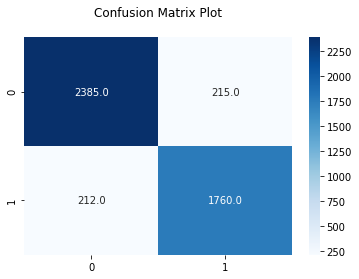

In [80]:
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.1f')
plt.title('Confusion Matrix Plot\n');